In [11]:
import os
from xml.etree import ElementTree
import matplotlib.pyplot as plt
import numpy as np

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion

    # skearn classifiers
from sklearn.neighbors import KNeighborsClassifier
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier

#random forest classifier
from sklearn.ensemble import RandomForestClassifier

#naive bayes classifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB, BernoulliNB

# support vector classifier
from sklearn.svm import SVC, LinearSVC



# nltk libraries
from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer

import preprocessor as tp
from gensim.parsing.preprocessing import remove_stopwords

In [12]:
config = {
    'dataset_name': 'PAN 2018 English',
    'xmls_directory': '../data/pan18-author-profiling-training-dataset-2018-02-27/en/text/',
    'truth_path': '../data/pan18-author-profiling-training-dataset-2018-02-27/en/en.txt',
    'txts_destination_directory': '../data/pan18-author-profiling-training-dataset-2018-02-27/en',
}


In [13]:
def load_data(xmls_directory, truth_path, txts_destination_directory):
    """ 
    Loads Pan data

    @return: 
    1. merged tweets of authors
    2. truths(read genders of the authors)
    3. author ids
    4. original tweet lengths of authors

    @TODO:
        Make sure that the data is read properly and is not misaligned
    """

    # read tweets of the authors
    # read the filenames from the xmls_dir
    xmls_filenames = sorted(os.listdir(xmls_directory))

    # xml filename = (author_id.xml)
    # to ge author id: split(filename)[0]
    author_ids = []
    for xml_filename in xmls_filenames:
        author_ids.append(xml_filename[:-4])

    #### truths --> go to truth location
    # split(:::)
    # get the first element
    # make sure that order is same in both cases, we are mapping the same things
    # since, author ids are sorted, hence truth file should be sorted as well
    truths_temp = []
    with open(truth_path, 'r') as truth_file:
        # sort ids
        for line in sorted(truth_file):

            line.rstrip('\n')

            entry = line.split(':::')
            truths_temp.append(entry)

    truths = []
    # make sure allignment is correct
    for author_idx, truth_vector in enumerate(truths_temp):

        if(author_ids[author_idx] != truth_vector[0]):
            print(author_ids[author_idx], truths_temp[0])
            print("Ids in truths file and Ids in author ids array do not align")
            return
        truths.append(truth_vector[1])

    ############# truths are constructed as well ###########################
    ##### form: merged tweets a
nd original tweet lengths of authors ########

    # files are xml files 
    # we need ElementTree module
    original_tweet_lengths = []

    merged_tweets = []

    # get filenames and read tweets
    for author_idx, xml_filename in enumerate(xmls_filenames):
        # read filename
        # construct tree of xml
        tree = ElementTree.parse(os.path.join(xmls_directory, xml_filename), parser = ElementTree.XMLParser(encoding = 'utf-8'))

        # get the root element of file
        root = tree.getroot()

        original_tweet_lengths.append([])

        tweets_of_this_author = []

        # root[0] --> first level of the tree
        # since the tweets are in 1st level 
        for child in root[0]:

            tweet = child.text 

            original_tweet_lengths[author_idx].append(len(tweet))

            # replace \n with lineFeed
            tweet.replace('\n', '<LineFeed>')

            tweets_of_this_author.append(tweet)

        
        # store tweets as string
        # string separated by <EndOfTweet> 
        merged_tweets_of_this_author = "<EndOfTweet>".join(tweets_of_this_author)+"<EndOfTweet>"

        merged_tweets.append(merged_tweets_of_this_author)

    return merged_tweets, truths, author_ids, original_tweet_lengths

In [14]:
print("Starting the project...")

    ### 1 -> Read the data from the files
merged_tweets, truths, author_ids, original_tweet_lengths = load_data(config['xmls_directory'],  
config['truth_path'], config['txts_destination_directory'])
print("Loaded Pan data")

Starting the project...
Loaded Pan data


In [15]:
docs_train, docs_test, y_train, y_test, author_ids_train, author_ids_test, original_tweet_lengths_train, original_tweet_lengths_test\
        = train_test_split(merged_tweets, truths, author_ids, original_tweet_lengths, test_size = 0.4, random_state = 42, stratify = truths)
print("Performed train test split")

    ##### maintain the order in dataset
author_ids_train, docs_train, y_train, original_tweet_lengths_train = [list(tuple) for tuple in zip(*sorted(zip(author_ids_train, docs_train, y_train, original_tweet_lengths_train)))]
    # Sort the test set
author_ids_test, docs_test, y_test, original_tweet_lengths_test = [list(tuple) for tuple in zip(*sorted(zip(author_ids_test, docs_test, y_test, original_tweet_lengths_test)))]

Performed train test split


In [84]:
######### pattern import########
import pattern
from pattern.en import lemma, lexeme

In [85]:
def preprocess_tweet(tweet):
    """
    This function will preprocess the input tweet

    Steps for preprocessing:
        1. Lowercase the letters
        2. Replace the characters with frequency greater than 3 with 3 in a word
        3. Replace a url with Tag: <URLURL>
        4. Replace a tag mention: <UsernameMention>

    
    @TODO:
        1. Look for better preprocessing methods on the web
        2. Apply here
    """
    clean_tweet = tp.clean(tweet)
    
    # perform lemmatization
    tokenizer = TweetTokenizer()
    tweet_tokens = tokenizer.tokenize(clean_tweet)
    lemmatizer = WordNetLemmatizer()
    # using stemming vs lemmatization 
    
    for token_idx, token in enumerate(tweet_tokens):
        tweet_tokens[token_idx] = lemmatizer.lemmatize(token, pos='a')

    ############### use pattern instead of WordnetLemmatizer
    # lme

    # lemmatized_tweet = ' '.join([lemma(token) for token in tweet_tokens])
    
    
    # remove stopwords
    preprocessed_tweet = remove_stopwords(lemmatized_tweet)
    return preprocessed_tweet

In [86]:
def extract_features(docs_train, docs_test, perform_dimensionality_reduction):
    """ 
    We will extract features from the dataset, preprocess it and return the X_train and X_test
    
    @return:
        1. X_train: Feature matrix for training data
        2. X_test: Feature matrix for test data


    @Regions of improvement:
        1. Get more features and use them to get more accurate predictions 
   
    """
    word_ngram_range = (1, 4)
    char_ngram_range = (2, 5)

    '''
    Build a char_vectorizer and combine word_vectorizer and char_vectorizer to make an n_grams vectorizer
    '''

    word_vectorizer = TfidfVectorizer(preprocessor=preprocess_tweet,
                                    analyzer='word',
                                    ngram_range=word_ngram_range,
                                    min_df=2,
                                    use_idf=True, 
                                    sublinear_tf=True)

    char_vectorizer = TfidfVectorizer(preprocessor=preprocess_tweet,
                                     analyzer='char', 
                                     ngram_range=char_ngram_range,
                                     min_df=2, 
                                     use_idf=True, 
                                     sublinear_tf=True)




    ###############################################################################################
    ################## Count vectorizer -> which just computes the count of tokens ################


    '''
    Merge the two vectorizers using a pipeline
    '''
    ngrams_vectorizer = Pipeline([('feats', FeatureUnion([
                                                        ('word_ngram', word_vectorizer),
                                                         ('char_ngram', char_vectorizer)
                                                         ])),
                                 # ('clff', LinearSVC(random_state=42))
                                 ])
    


    # fitTransform this thing 
    X_train = ngrams_vectorizer.fit_transform(docs_train) #it will take a lot of time... i think
    X_test = ngrams_vectorizer.transform(docs_test)
    print("Performed fitting of data")
    ############ perform dimensionality reduction ################
    
    if(perform_dimensionality_reduction == True):                                 

        print("Performing dimensionality reduction")
        # use TruncatedSVD to reduce dimensionality of our dataset
        svd = TruncatedSVD(n_components = 300, random_state = 42)

        X_train = svd.fit_transform(X_train)
        X_test = svd.transform(X_test)
        print("Performed dimensionality reduction")


    # print(docs_train[0])
    return X_train, X_test


In [87]:
X_train, X_test = extract_features(docs_train, docs_test, perform_dimensionality_reduction=True)
print("Successfully extracted features from the documents")

Performed fitting of data
Performing dimensionality reduction
Performed dimensionality reduction
Successfully extracted features from the documents


In [88]:
X_train_copy = X_train
X_test_copy = X_test


In [43]:
### reset X_test and X_train
X_train = X_train_copy
X_test = X_test_copy

In [5]:
# tests on average tweet length
def get_average_tweet_lengths(tweet_lengths):
    average_tweet_lengths = []
    for tweet_length in tweet_lengths:
        # calc average
        total_tweet_len = 0
        for length in tweet_length:
            total_tweet_len += length

        average_tweet_lengths.append(total_tweet_len / len(tweet_length))
    return np.array(average_tweet_lengths)


# do same for X_test 

# then classify

In [ ]:
######### Topics
# Tfidf   
# CountVectorizer
# Pipeline
# FeatureUnion

In [89]:
def train_and_test_model(clf, X_train, y_train, X_test, y_test):
    # training phase
    # fit the X_train, y_train on the clf
    clf.fit(X_train, y_train)

    '''
    Predict the output of the test set
    '''
    y_predicted = clf.predict(X_test)

    '''
    Build the confusion matrix
    '''
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)

    plt.imshow(confusion_matrix)

    plt.set_cmap('jet')

    plt.show()


    ###################### print the accuracy of our classifier ###########################
    accuracy = metrics.accuracy_score(y_test, y_predicted, normalize = True)
    print(f'Accuracy of our classifier is : {accuracy}')

    ################# f-major score #########################
    f_major = metrics.f1_score(y_test, y_predicted, average='micro')
    print(f'F-Major of our classifier is : {f_major}')

    ################# precesion ##############################
    precision = metrics.precision_score(y_test, y_predicted, average='micro')
    print(f'Precision of our classifier is {precision}')



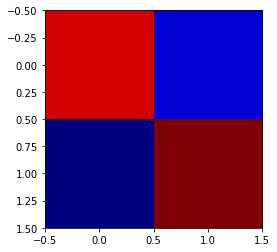

Accuracy of our classifier is : 0.8058333333333333
F-Major of our classifier is : 0.8058333333333333
Precision of our classifier is 0.8058333333333333
Done training the dataset...


In [90]:
 clf = LinearSVC(random_state = 42, tol = 0.3)

# Knn
# clf = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', p=3)

# decision Tree
# clf = DecisionTreeClassifier(criterion='entropy', random_state=0)

# random forest 
# clf = RandomForestClassifier(n_estimators=1000)

train_and_test_model(clf, X_train, y_train, X_test, y_test)
print("Done training the dataset...")